<a href="https://colab.research.google.com/github/nehasingh112/basics/blob/master/Copy_of_P2_Dataset_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA and Visualization: 
###Introduction of P2 dataset through visualization and statistics for introductory purposes such as wordcloud, frequency analysis (unigram, bi-gram, trigram etc), topic modeling, clustering etc.

In [5]:
#!pip install textstat
#!pip install pyldavis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import wordcloud
import spacy
import textblob
import gensim
import sklearn
#import pyldavis
#import textstat


## Loading the dataset

In [6]:
#loading the dataset 
data = pd.read_csv("/content/news.csv")
news = data[['sentiment','sales_relevancy', 'KYC_relevancy', 'text', 'labeler']]
news.head(5)

,sentiment,sales_relevancy,KYC_relevancy,text,labeler
0,neutral,1.0,1.0,"According to Gran , the company has no plans t...",Jack
1,neutral,1.0,1.0,Technopolis plans to develop in stages an area...,Jack
2,negative,0.0,1.0,The international electronic industry company ...,Jack
3,neutral,1.0,0.0,With the new production plant the company woul...,Jack
4,neutral,1.0,0.0,According to the company 's updated strategy f...,Jack


##Class Label distribution and visualization


In [4]:
news.describe()

,sales_relevancy,KYC_relevancy
count,6156.000000,6484.000000
mean,0.121345,0.374923
std,0.326554,0.498271
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,10.000000


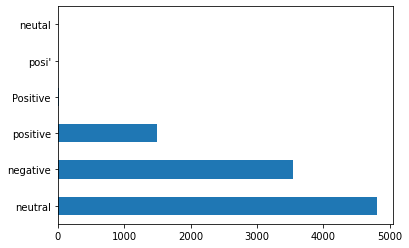

In [5]:
news['sentiment'].value_counts().plot(kind='barh')


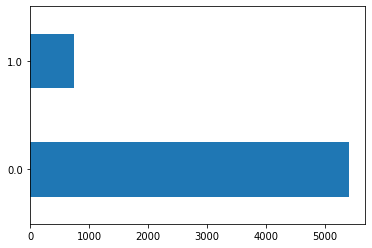

In [6]:
news['sales_relevancy'].value_counts().plot(kind='barh')


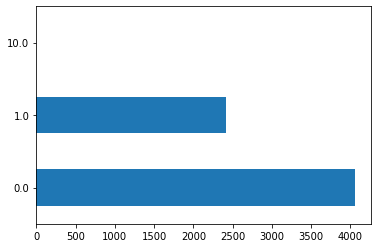

In [7]:
news['KYC_relevancy'].value_counts().plot(kind='barh')


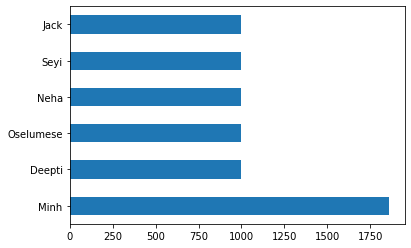

In [8]:
news['labeler'].value_counts().plot(kind='barh')


## word/character/length of text distribution

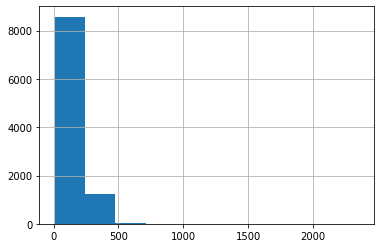

In [9]:
# number of characters present in each news line. for a rough idea about the news headline length.
news['text'].str.len().hist()


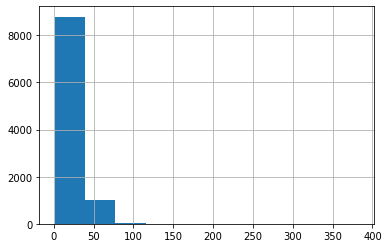

In [10]:
#word-level plot the number of words appearing in each news headline.

news['text'].str.split().map(lambda x: len(x)).hist()


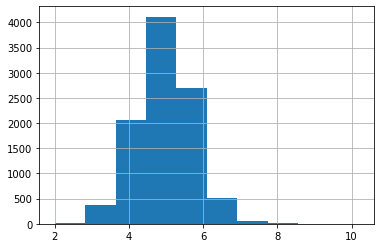

In [11]:
#average word length
news['text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

## Stopword & non-stopword high frequent word visualization


In [18]:
# Code Snippet for Top Stopwords Barchart

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


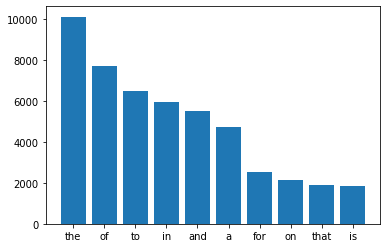

In [19]:
plot_top_stopwords_barchart(news['text'])

In [20]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)


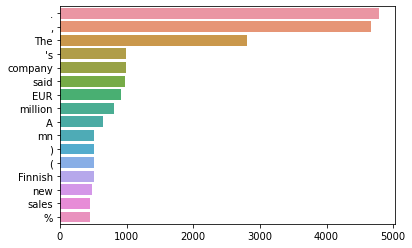

In [21]:
#non-stop work visualization
plot_top_non_stopwords_barchart(news['text'])


##Ngram exploration


In [22]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

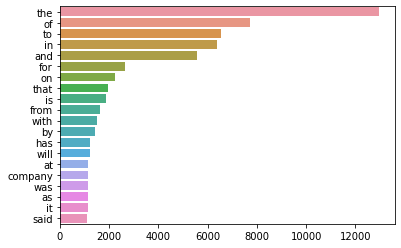

In [23]:
plot_top_ngrams_barchart(news['text'],1)


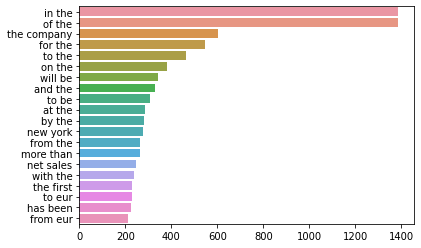

In [24]:
plot_top_ngrams_barchart(news['text'],2)


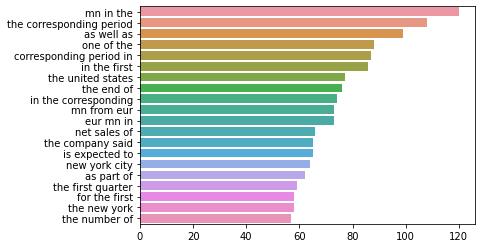

In [25]:
plot_top_ngrams_barchart(news['text'],3)


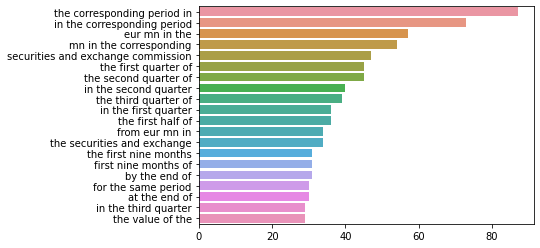

In [26]:
plot_top_ngrams_barchart(news['text'],4)

## Topic modeling exploration

### pre-process: tokenize (list of tokens or words), remove stopwords, lemmatize (reduces to a common base/root word), convert to the bag of words (Dictionary where the keys are words(or ngrams/tokens) and values are the number of times each word occurs in the corpus)



In [27]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize


def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['text']:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(news)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [28]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
#and we can finally create the LDA model:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

In [37]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
stops =  set(stopwords.words('english')+['com']+['the']+['to']+['of']+['in']+['and']+['for']+['that']+['is']+['with']+['by']+['has']+['will']+['at'])

vectorizer = CountVectorizer(stop_words=stops)
model = vectorizer.fit(news.text)
docs = vectorizer.transform(news.text)
lda = LatentDirichletAllocation(15)
lda.fit(docs)
def print_top_words(model, feature_names, n_top_words):
  for topic_idx, topic in enumerate(model.components_):
    message = "Topic #%d: " % topic_idx
    message += " ".join([(feature_names[i])
    for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)
  print()
print_top_words(lda,vectorizer.get_feature_names(),10)

Topic #0: new services said company business äôs customers data mobile industry
Topic #1: company said market real air pollution estate äôs helsinki share
Topic #2: new äôs market two state said one countries business äù
Topic #3: shares board new äôs company directors million 000 share rights
Topic #4: finland finnish company said group oy production construction 2010 contract
Topic #5: eur share per mn percent million year shares earnings value
Topic #6: former million äôs new charges federal money said guilty charged
Topic #7: company nokia mobile said solutions services years software technology people
Topic #8: new äôs äù court company could york says said one
Topic #9: new äôs york two one city said security police market
Topic #10: card credit äôs new debit äù also year company cards
Topic #11: eur sales net million mn profit year mln period 2008
Topic #12: bank äôs federal said rs money banks two fraud police
Topic #13: bank said police rs äôs companies company private state ar

## wordcloud


In [38]:
# Code Snippet for Wordcloud

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


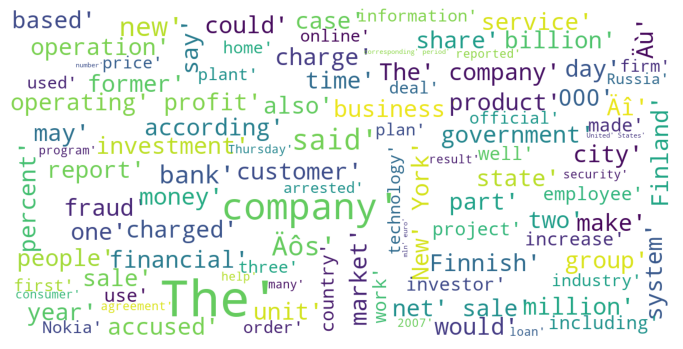

In [39]:
plot_wordcloud(news['text'])


## NER Modeling 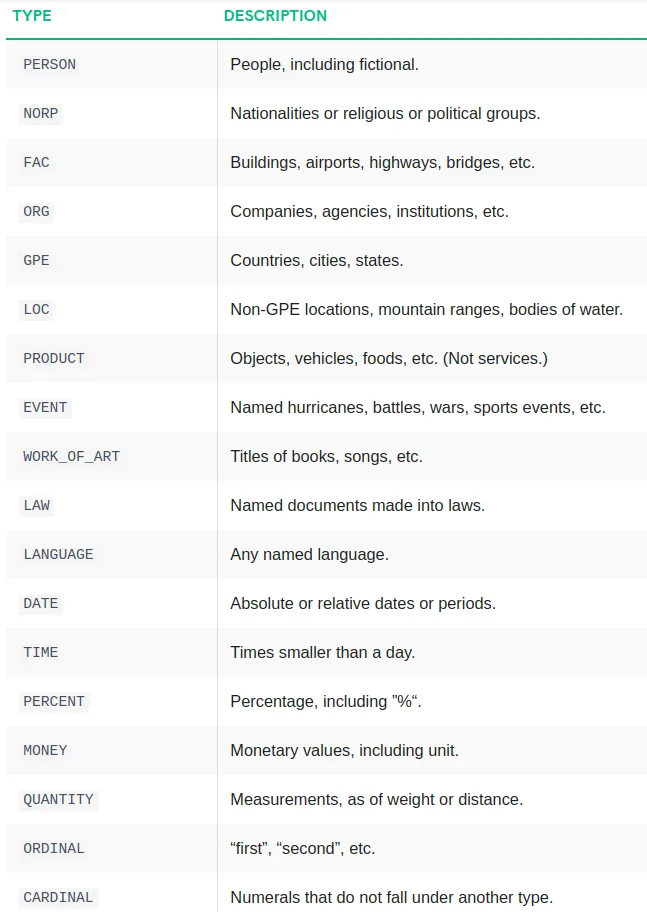

In [40]:
 #Code Snippet for Named Entity Barchart

import spacy
from collections import  Counter
import seaborn as sns

def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)


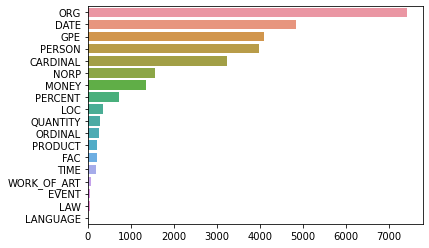

In [41]:
plot_named_entity_barchart(news['text'])

In [42]:
# Code Snippet for Most Common Named Entity Barchart

import spacy
from collections import  Counter
import seaborn as sns

def plot_most_common_named_entity_barchart(text, entity="PERSON"):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(y,x).set_title(entity)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


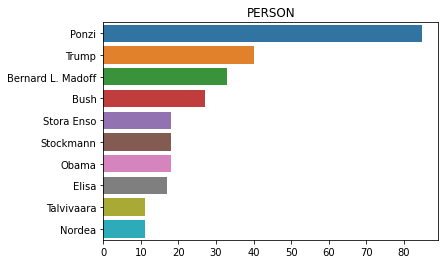

In [43]:
plot_most_common_named_entity_barchart(news['text'], entity="PERSON")


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


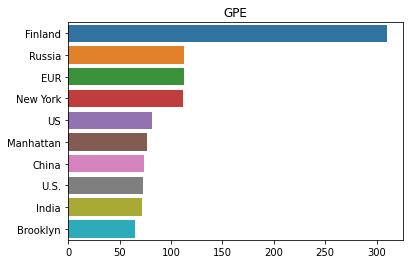

In [44]:
plot_most_common_named_entity_barchart(news['text'], entity="GPE")


In [ ]:
plot_most_common_named_entity_barchart(news['text'], entity="ORG")


In [ ]:
plot_most_common_named_entity_barchart(news['text'], entity="CARDINAL")


In [ ]:
plot_most_common_named_entity_barchart(news['text'], entity="NORP")


In [ ]:
plot_most_common_named_entity_barchart(news['text'], entity="PRODUCT")


In [ ]:
plot_most_common_named_entity_barchart(news['text'], entity="LOC")


## Unsupervised Sentiment analysis for comparision 
###  VADER(Valence Aware Dictionary and Sentiment Reasoner),a rule/lexicon-based, open-source sentiment analyzer pre-built library, protected under the MIT license. Generally works better in detecting negative sentiment, very useful in the case of social media text sentiment analysis.


In [7]:
# Code Snippet for Sentiment Barchart

from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,
            sentiment.value_counts())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


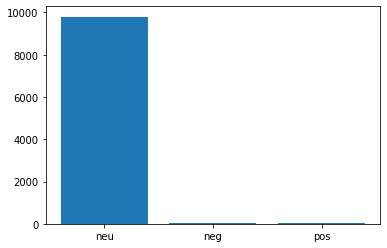

In [8]:
plot_sentiment_barchart(news['text'], method='Vader')


## CLUSTERING
### K-MEANS

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import TfidfVectorizer
# Represent each article as a vector
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(news['text'])



In [ ]:
# Perform k-means clustering

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
news_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(news_cl.sort_values(by=['cluster']))

In [ ]:
#Evaluate the result
from wordcloud import WordCloud
result={'cluster':labels,'news':news['text']}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['news'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   titles=wiki_cl[wiki_cl.cluster==k]['title']         
   print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()